### load parflow package

We will import parflow to read the PFIDB file and use these keys in setting up the EcoSLIM run.


In [1]:
#load the parflow python module
from parflow import Run
from parflow.tools.io import read_pfb,  write_pfb
import os 

In [2]:
# Function to write the EcoSLIM input file
# static_write_dir: directory to write the input file
# slimrunname: name of the EcoSLIM run
# pfrunname: name of the ParFlow run
# nx: number of cells in the x direction
# ny: number of cells in the y direction
# nz: number of cells in the z direction
# npinit: number of particles per cell at the start of the simulation, negative values are used to specify a river input
# nptotal: total number of particles
# dx: cell size in the x direction
# dy: cell size in the y direction
# dz: cell sizes in the z direction
# runtime: run time in hours
# velocity_multiplier: velocity multiplier (1.0=forward, -1.0=backward)
# CFL: fraction of Dx/Vx for numerical stability since this controls the time step which is also used to write out the particle locations, it controls the spatial resolution of the particle locations
def write_EcoSLIM_inputfile(static_write_dir,slimrunname, pfrunname,nx,ny,nz,npinit,nptotal,dx,dy,dz,runtime,velocity_multiplier,CFL,streamfile,maskfile,particleinputfile):
    inputfile = open(static_write_dir+"/"+"slimin.txt", "w")
    inputfile.write(f"{slimrunname}   ! SLIM run name \n")
    inputfile.write(f"\"{pfrunname}\"  \n")
    inputfile.write("\"dem.pfb\"  \n")
    inputfile.write(f"{nx}    !nx \n{ny}   !ny  \n{nz}     !nz \n")
    inputfile.write(f"{npinit}     !particles per cell at start of simulation \n")
    inputfile.write(f"{nptotal}   !np Total \n")
    inputfile.write(f"{dx}     !dx  \n")
    inputfile.write(f"{dy}     !dy, dz follows  \n")
    for i in range(0, len(dz)):
        inputfile.write(f"{dz[i]} ")
    inputfile.write(f" \n")
    inputfile.write(f"{runtime}   ! run time in hours     \n")
    inputfile.write("1        ! Parflow t1: ParFlow file number to start from (initial condition is pft1-1) \n")
    inputfile.write("1        ! Parflow t2: ParFlow file number to stop at   \n")
    inputfile.write("0          ! EcoSLIM output start counter 0=pft1            \n")
    inputfile.write("0.0        ! Particle start time counter (for recording particle insert times)\n")
    inputfile.write("1          ! Time Sequence Repeat [n_cycle*(pft2-pft1)]\n")
    inputfile.write("-1         ! ipwrite frequency, controls an ASCII, .3D particle file not recommended due to poor performance\n")
    inputfile.write("0         ! ibinpntswrite frequency, controls VTK, binary output of particle locations and attributes\n")
    inputfile.write("0         !  etwrite frequency, controls ASCII ET output\n")
    inputfile.write("0        ! icwrite frequency,controls VTK, binary grid based output where particle masses, concentrations\n")
    inputfile.write(f"{velocity_multiplier}d0       ! velocity multiplier 1.0=forward, -1.0=backward\n")
    inputfile.write("False           ! CLM Evap Trans\n")
    inputfile.write("False           ! CLM Variables Read logical\n")
    inputfile.write("0          ! number of particles per Evap Trans IC\n")
    inputfile.write("1000.0       ! density H2O\n")
    inputfile.write("0.0   ! Molecular Diffusivity\n")
    inputfile.write(f"{CFL}d0        ! fraction of Dx/Vx for numerical stability\n")
    inputfile.write("0            ! Number of indicators provided. If this value is great than 0 an indicator file must be included\n")
    inputfile.write("\"\" ! Name of the indictor file to use set to '' if not using an indicator file \n")
    inputfile.write(".False. \n")  # no velfile
    inputfile.write(".False. \n")  # no boolfile
    inputfile.write(f"{maskfile} \n")  # mask input file
    inputfile.write(f"{streamfile} \n")  # stream input file
    inputfile.write(f"{particleinputfile} \n")  # particle input file
    inputfile.close()


### load ParFlow run from the key database
We load the ParFlow run and assign EcoSLIM variables to correspond with the corresponding keys (e.g. nx, ny, etc).  We then assign EcoSLIM specific variables and call the function that writes out the EcoSLIM input file.


In [ ]:
# Define the run name and the directory where the run is located
# This is the directory where the ParFlow run is located and where the EcoSLIM input file will be written
# it needs be changed by the user
static_write_dir="/path/to/where/you/ran/huc0205"
runname = "HUC0205"

# EcoSLIM directory
# This is the directory where the EcoSLIM executable is located
# it needs be changed by the user
# note that the EcoSLIM executable is located in the EcoSLIM/build directory
# note that this is a custom build of EcoSLIM that has been modified to work with reverse particle tracking
ecoslimdir = "/path/to/ecoslim/EcoSLIM/build"

# assign the EcoSLIM run name
slimrunname = "SLIM_0205"

runname_file = static_write_dir + "/" + runname +'.pfidb'

# load a ParFlow run object
run = Run.from_definition(runname_file)
data = run.data_accessor # get the data accessor, this makes it easier to access the data from the run

nx = data.shape[2]    # get the number of cells in the x direction
ny = data.shape[1]    # get the number of cells in the y direction
nz = data.shape[0]    # get the number of cells in the z direction
dx = data.dx          # get the cell size in the x direction
dy = data.dy          # get the cell size in the y direction
dz = data.dz          # get the cell size in the z direction, this is a 1D array of size nz

# EcoSLIM parameters
npinit = -2     # river IC
nptotal = 100000  # max number of particles to release
runtime= 10000000000.0  #total EcoSLIM run time in hours
velocity_multiplier = 1.0   # -1.0=backward, 1.0=forward
CFL = 0.4  # fraction of Dx/Vx for numerical stability
streamfile = 'streams.pfb' # stream input file
maskfile = 'mask.pfb'  # mask input file
particleinputfile = 'uog_mask.pfb'  # particle input file is the stream file for this case

# write the EcoSLIM input file
write_EcoSLIM_inputfile(static_write_dir,slimrunname,runname,nx,ny,nz,npinit,nptotal,dx,dy,dz,runtime,velocity_multiplier,CFL,streamfile,maskfile,particleinputfile)

# run EcoSLIM
os.chdir(static_write_dir)
os.system(ecoslimdir+"/EcoSLIM.exe")

 *** Running EcoSLIM ***
 Run Name: SLIM_UOG_0205                                                                                                                                                                                           
 ParFlow Run Name: HUC0205                                                                                                                                                                                                 
 See SLIM_UOG_0205_log.txt for more information
 Reading ParFlow output files
 Reading:HUC0205.out.velx.00001.pfb                                                                                                                                                                              
 Reading:HUC0205.out.vely.00001.pfb                                                                                                                                                                              
 Reading:HUC0205.out.velz.00001.pfb          

0

In [4]:
import numpy as np
import pandas as pd
# read the EcoSLIM output file, variables are defined as follows:
#  P(np,1) = X coordinate [L]
#  P(np,2) = Y coordinate [L]
#  P(np,3) = Z coordinate [L]
#  P(np,4) = Particle residence time [T]
#  P(np,5) = Saturated particle residence time [T]
#  P(np,6) = Particle mass; assigned via precipitation or snowmelt rate (Evap_Trans*density*volume*dT)
#  P(np,7) = Particle source (1=IC, 2=rain, 3=snowmelt...)
#  P(np,10) = Exit status (1=surface outflow, 2=ET, 3=subsurface outflow)
#  P(np,11) = Particle Number (This is a unique integer identifier for the particle)
#  P(np,16) = Length of flow path [L]
#  P(np,17) = Length of saturated flow path [L]
inputfile = static_write_dir + "/" + slimrunname + "_streamline_trace.bin"
P = np.fromfile(inputfile, dtype=np.float64)
# read order is : P(ii,1), P(ii,2), P(ii,3), P(ii,4), P(ii,5), P(ii,6), P(ii,7), P(ii,10), P(ii,11), P(ii,16), P(ii,17)
print(np.shape(P))
print((len(P)/11))
P=np.reshape(P, (int(len(P)/11), 11))
print(np.shape(P))
# print out the first particle location
print("X Y Z Time SatTime Mass Source ExitStatus ParticleNumber LengthFlowPath LengthSaturatedFlowPath")
np.set_printoptions(precision=3, suppress=True)
print(P[0,:])

# convert the numpy array to a pandas dataframe
pdf = pd.DataFrame(P, columns=["X", "Y", "Z", "Time", "SatTime", "Mass", "Source", "ExitStatus", "ParticleNumber", "LengthFlowPath", "LengthSaturatedFlowPath"])   
# print out the first 5 rows of the dataframe
print(pdf.head())

(846307,)
76937.0
(76937, 11)
X Y Z Time SatTime Mass Source ExitStatus ParticleNumber LengthFlowPath LengthSaturatedFlowPath
[   14405.314   158782.64       391.58      4266.719     4266.719
 19812249.668        1.           0.           1.           0.561
        0.561]
              X              Y       Z          Time       SatTime  \
0  14405.314284  158782.640174  391.58   4266.719065   4266.719065   
1  14404.317643  158782.160860  391.34  12862.690849  12862.690849   
2  14403.299353  158781.667106  391.10  21628.051089  21628.051089   
3  14402.258499  158781.158179  390.86  30569.609769  30569.609769   
4  14400.540430  158778.562890  390.46  45869.797209  45869.797209   

           Mass  Source  ExitStatus  ParticleNumber  LengthFlowPath  \
0  1.981225e+07     1.0         0.0             1.0        0.560974   
1  1.981225e+07     1.0         0.0             1.0        1.692626   
2  1.981225e+07     1.0         0.0             1.0        2.849478   
3  1.981225e+07     1.

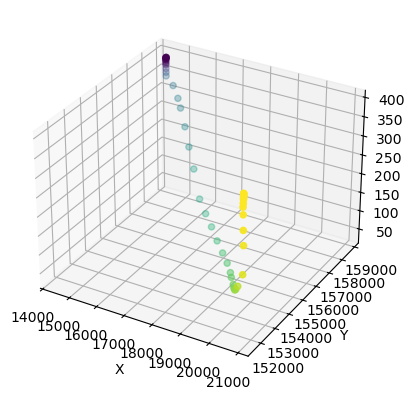

In [17]:
# example 1: plot the particle path of particle number 10
# plot a particle path in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
particle_number = 1.0
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pdf['X'].where(pdf['ParticleNumber'] == particle_number), pdf['Y'].where(pdf['ParticleNumber'] == particle_number), pdf['Z'].where(pdf['ParticleNumber'] == particle_number), c=pdf['Time'].where(pdf['ParticleNumber'] == particle_number))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


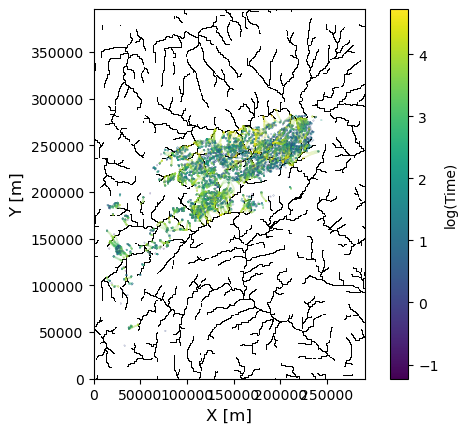

In [13]:
# example 2: plot a 2D map of all the particle paths as dots over a 2D map of the domain color coded by the particle Time


# load the streams file
filename = static_write_dir + "/streams.pfb"
data = read_pfb(filename) 
plt.imshow(data[0,:,:], cmap = "gray_r", origin='lower', interpolation='none', extent=[0, nx*dx, 0, ny*dy])


plt.scatter(pdf['X'], pdf['Y'],  c=np.log10(pdf['Time']/8760),marker='o', s=0.001,alpha=1.0,zorder=10)
plt.colorbar(label='log(Time)')
plt.xlabel('X [m]', fontsize=12)
plt.ylabel('Y [m]', fontsize=12)
plt.show()

In [14]:
# generate a histogram of the particle residence time
# first we find the end of the particle path, we do this by finding the increase in the particle number
pdf['ParticleNumberDiff'] = pdf['ParticleNumber'].diff(periods=-1)
# make a new data from with only the particle end locations
particle_end = pdf[pdf['ParticleNumberDiff'] < 0]
print(particle_end.loc[0:100])


               X              Y           Z          Time       SatTime  \
47  20868.449895  151655.480726  391.987124  6.418829e+07  4.223812e+07   
91  19448.494164  152645.386618  391.990272  4.991121e+07  2.796104e+07   

            Mass  Source  ExitStatus  ParticleNumber  LengthFlowPath  \
47  1.981225e+07     1.0         0.0             1.0     9913.212532   
91  1.981225e+07     1.0         0.0             2.0     7891.097430   

    LengthSaturatedFlowPath  ParticleNumberDiff  
47              9859.348927                -1.0  
91              7842.109505                -1.0  


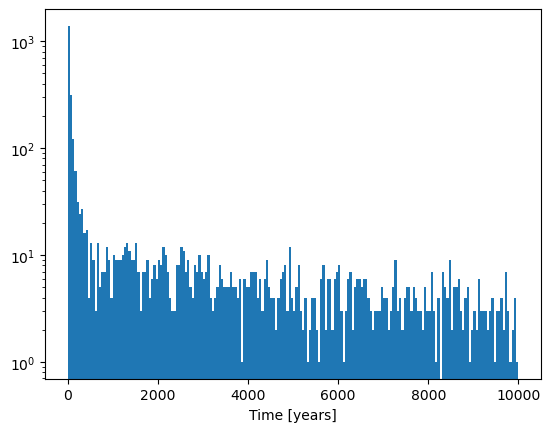

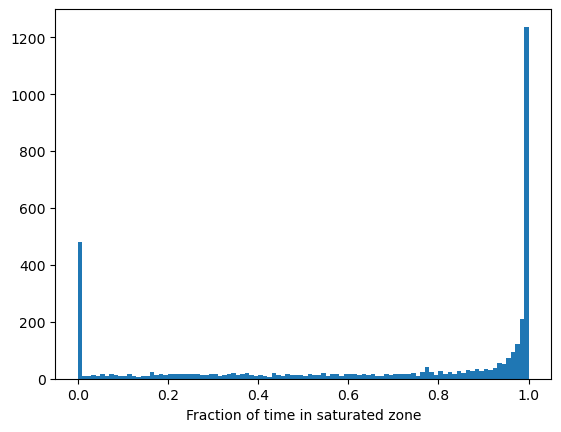

In [16]:
# now we plot the histogram of the particle residence time
# filter out the particles that have zero time
#particle_end = particle_end[particle_end['Time'] > 24]
# filter out particles that have a residence time greater than the total run time
#particle_end = particle_end[particle_end['Time'] < runtime]
plt.hist(particle_end['Time']/8760, bins=200, range=(1, 10000), log=True)
plt.xlabel('Time [years]')
plt.show()

plt.hist(particle_end['SatTime']/particle_end['Time'],bins=100)
plt.xlabel('Fraction of time in saturated zone')
plt.show()


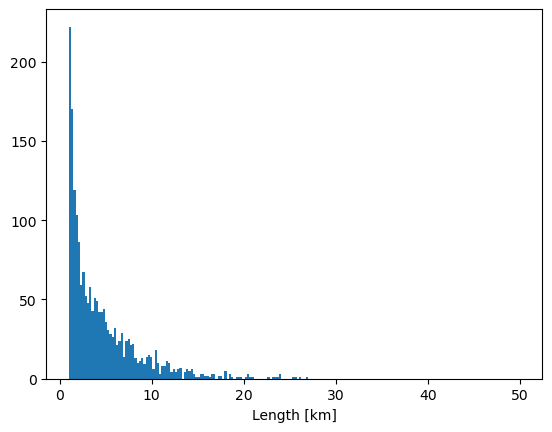

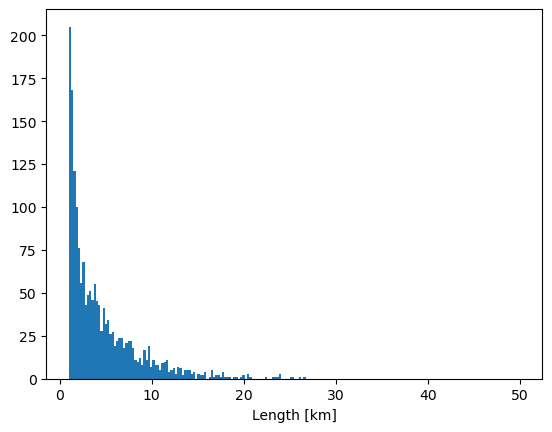

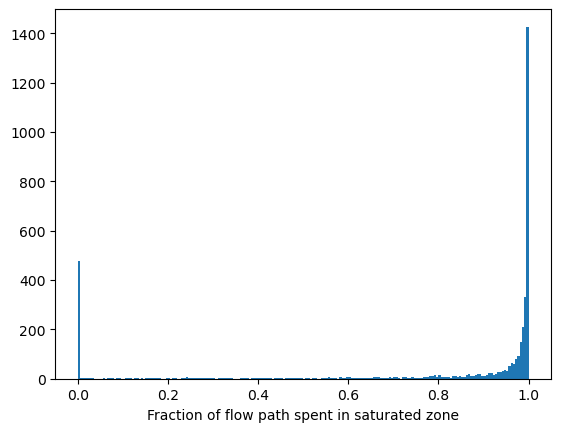

In [9]:
# now we plot the histogram of the particle lengths

plt.hist(particle_end['LengthFlowPath']/1000, bins=200, range=(1, 50))
plt.xlabel('Length [km]')
plt.show()
plt.hist(particle_end['LengthSaturatedFlowPath']/1000, bins=200, range=(1, 50))
plt.xlabel('Length [km]')
plt.show()

plt.hist((particle_end['LengthSaturatedFlowPath']/particle_end['LengthFlowPath']), bins=200) 
plt.xlabel('Fraction of flow path spent in saturated zone')
plt.show()